**Oppgave a)**

Laplace-ligningen gir $\nabla^2V(x,y)=\frac{\partial^2V}{\partial x^2}+\frac{\partial^2V}{\partial y^2}=0$. 

Diskretiserer vi dette til enkeltsteg $\Delta x = \Delta y$ kan vi skrive dette på formen $V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1})+4V(x_i,y_j)=0$. 
Noe som gir opphav til Gauss-Seidel metoden for å oppdatere potensialet:

\begin{equation}
V(x_i, y_j)= \frac{1}{4} \big( V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1}) \big)
\end{equation}

Her bruker jeg SOR metoden, som er en modifisert Gauss-Seidel:

\begin{equation}
V(x_i, y_j)= (1 - \omega)V(x_i, y_j) +  \frac{\omega}{4} \big( V(x_{i-1},y_j) + V(x_{i+1},y_j) + V(x_i,y_{j-1}) + V(x_i,y_{j+1}) \big)
\end{equation}


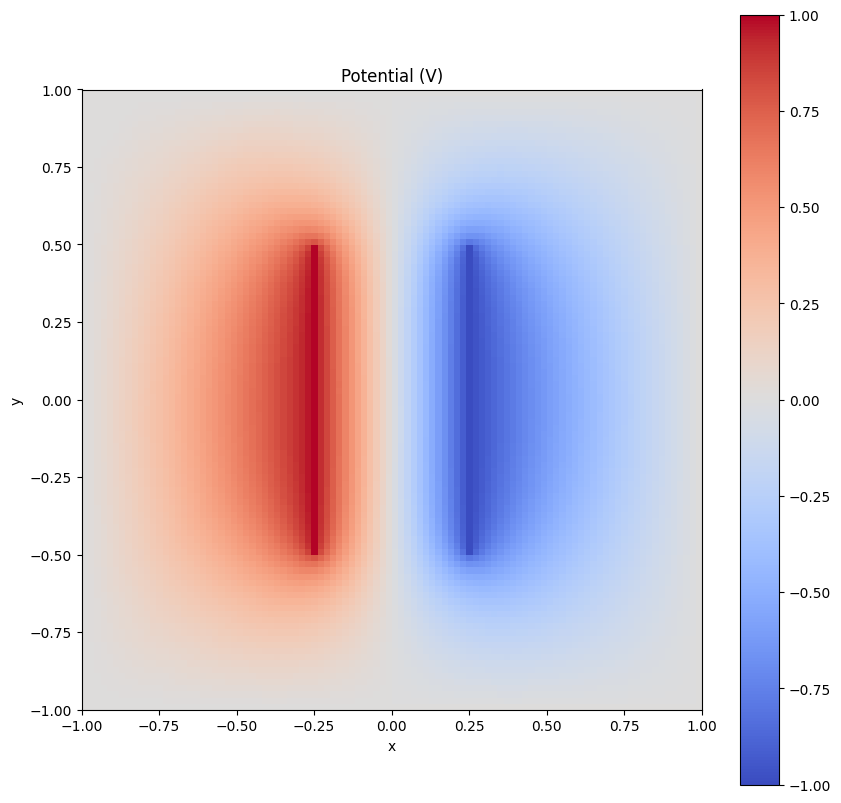

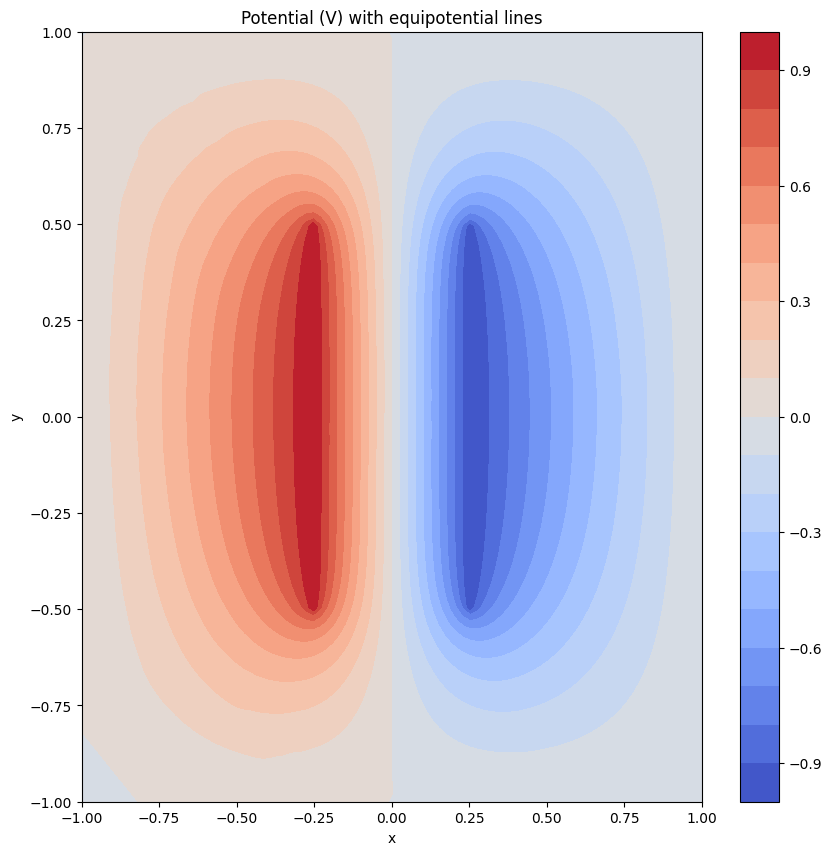

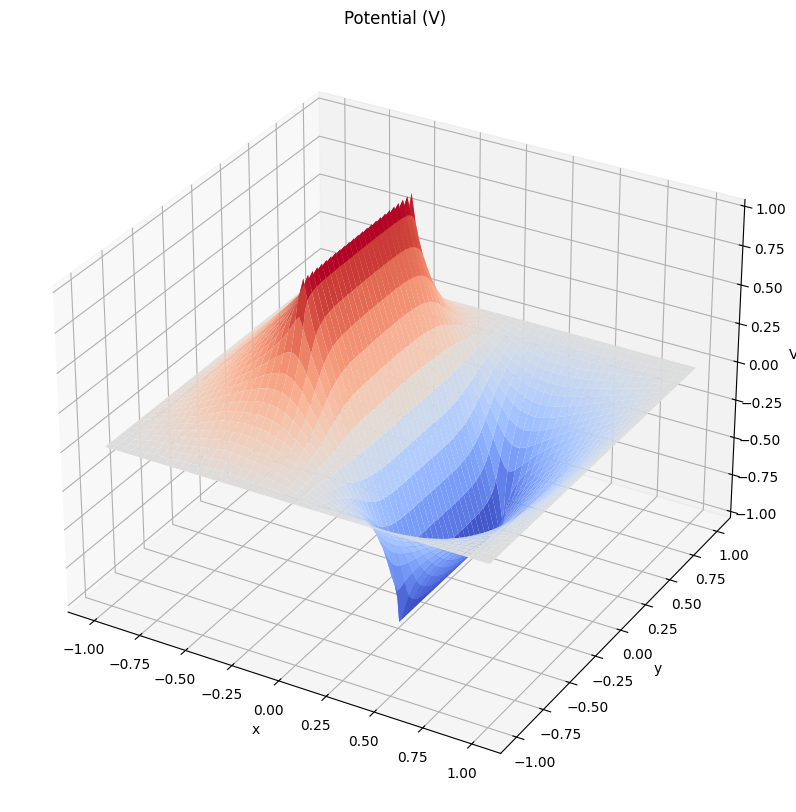

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plate_d = 0.5
omega = 1.9
n = 100
dist_tol = 1 / n

def SOR_step(V: np.ndarray, x: float, y: float, i: int, j: int, plate_x: float, first_iteration: bool = False) -> np.ndarray:

    # Jordet boks
    if i == 0 or i == len(V) - 1 or j == 0 or j == len(V[0]) - 1:
        V[i, j] = 0
        return V

    # Plater
    if -0.5 <= y <= 0.5:
        # Venstre plate
        if -plate_x-dist_tol <= x <= -plate_x+dist_tol:
            V[i, j] = 1
            return V

        # Høyre plate
        if plate_x-dist_tol <= x <= plate_x+dist_tol:
            V[i, j] = -1
            return V
    
    # På første iterasjon fyller vi kun inn grenseverdiene
    if first_iteration:
        return V

    # SOR
    V[i, j] = (1-omega) * V[i,j] + (omega/4) * (V[i-1, j] + V[i+1, j] + V[i, j-1] + V[i, j+1])
    return V


def SOR(mesh: tuple[np.ndarray], tol: float = 1e-1, plate_d: float = plate_d):
    """
    SOR-metoden for å løse Laplace's ligning numerisk. Iterativ metode som sammenligner verdier fra forrige iterasjon
    for å sjekke konvergens.
    """

    # initialiserer delta som uendelig
    delta = np.inf

    x_mesh, y_mesh = mesh

    V = np.zeros((len(x_mesh[0]), len(x_mesh[1])))
    last_V = np.copy(V)

    first_iteration = True
    plate_x = plate_d/2

    while delta > tol:
        for i in range(len(V)):
            for j in range(len(V[0])):
                x, y = x_mesh[i, j], y_mesh[i, j]
                V = SOR_step(V, x, y, i, j, plate_x, first_iteration)
        
        if first_iteration:
            first_iteration = False
            continue

        delta = np.linalg.norm(V - last_V)
        last_V = np.copy(V)
    
    return V


mesh = np.meshgrid(np.linspace(-1, 1, n), np.linspace(-1, 1, n))
V = SOR(mesh)

# Plotter som heatmap
plt.figure(figsize=(10, 10))
plt.imshow(V, extent=[-1,1,-1,1], cmap='coolwarm')
plt.title('Potential (V)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Plotter som contour, tilsvarer ekvipotensiallinjer
plt.figure(figsize=(10, 10))
plt.contourf(mesh[0], mesh[1], V, cmap='coolwarm', levels=20)
plt.title('Potential (V) with equipotential lines')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Plotter som 3D overflate
plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(mesh[0], mesh[1], V, cmap='coolwarm')
plt.title('Potential (V)')
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('V')
plt.show()



**Oppgave b)**

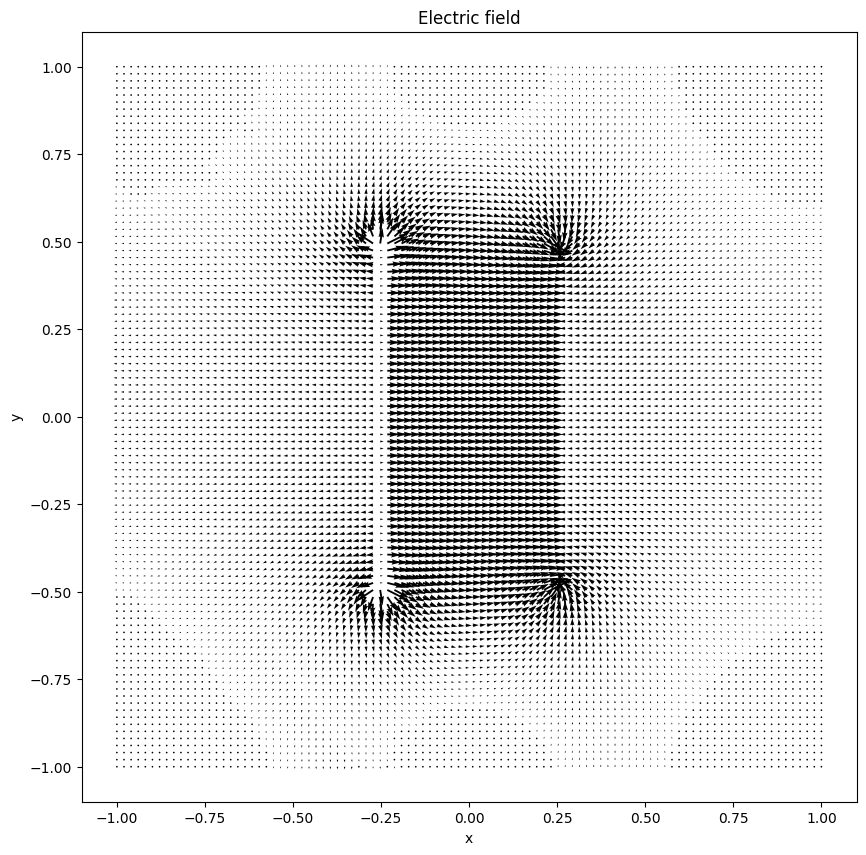

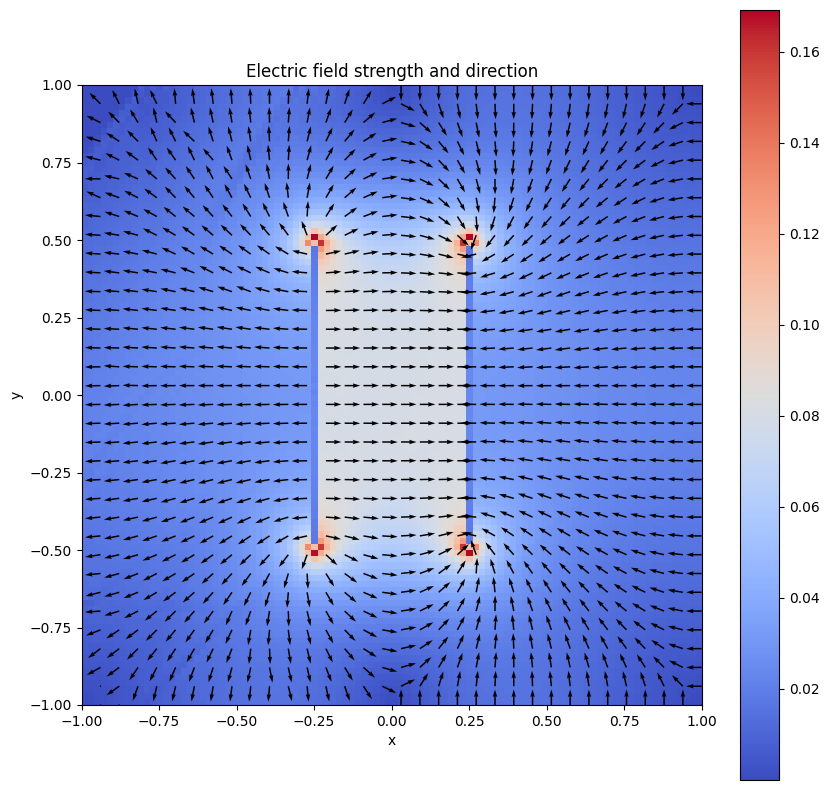

In [ ]:
V = SOR(mesh)
gradient = np.gradient(V)

# Finner E = -grad(V)
E_x = -gradient[1]
E_y = -gradient[0]

# Plotter feltet som et vektorfelt
plt.figure(figsize=(10, 10))
plt.quiver(mesh[0], mesh[1], E_x, E_y)
plt.title('Electric field')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

E = np.sqrt(E_x**2 + E_y**2)

# Fjerner muligheten for å dele på 0
E_x = np.where(E < 1e-6, 0, E_x)
E_y = np.where(E < 1e-6, 0, E_y)
E = np.where(E < 1e-6, 1e-6, E)

# Normaliserer vektorene
E_x_norm = E_x / E
E_y_norm = E_y / E

# Plotter feltstyrken som heatmap
plt.figure(figsize=(10, 10))
plt.imshow(E, extent=[-1,1,-1,1], cmap='coolwarm')
plt.colorbar()

# Plotter feltretningen som vektorer. Velger hver 3. vektor i hver retning for å unngå for mange vektorer
plt.quiver(mesh[0][::3, ::3], mesh[1][::3, ::3], E_x_norm[::3, ::3], E_y_norm[::3, ::3], scale=20, scale_units='xy')
plt.title('Electric field strength and direction')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Oppgave c)**

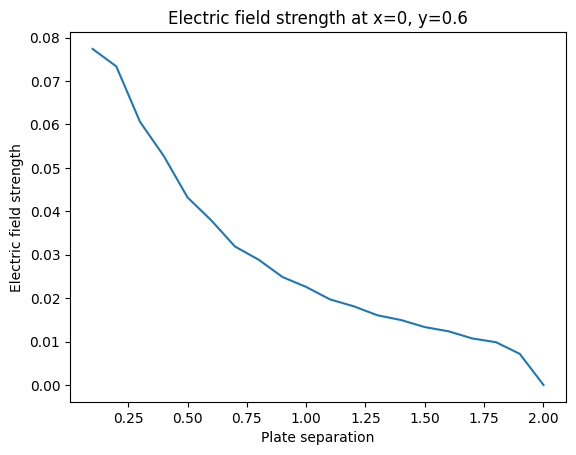

In [19]:
ds = np.linspace(0.1, 2, 20)

# Finner nermeste punkt i mesh til målepunktet
measure_position = (0, 0.6)
measure_idx = (np.abs(mesh[0][0] - measure_position[0])).argmin()
measure_idy = (np.abs(mesh[1][:, 0] - measure_position[1])).argmin()

E_measure = []
# Måler feltstyrken ved y=0.6 for forskjellige plateavstander
for d in ds:
    V = SOR(mesh, plate_d=d)
    gradient = np.gradient(V)
    E_x = -gradient[1]
    E_y = -gradient[0]
    E = np.sqrt(E_x**2 + E_y**2)
    E_measure.append(E[measure_idy, measure_idx])

# Plotter feltstyrken i (0, 0.6) som funksjon av plateavstanden
plt.figure()
plt.plot(ds, E_measure)
plt.title('Electric field strength at x=0, y=0.6')
plt.xlabel('Plate separation')
plt.ylabel('Electric field strength')
plt.show()